In [1]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [2]:
sentences = LineSentence("../data/sense-token-asbc5-600k.txt")

In [3]:
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4)

In [4]:
wv = model.wv

In [191]:
wv.save("../data/sense-emb-asbc5-600k.kv")

In [6]:
from CwnGraph import CwnBase, CwnSense
cwn = CwnBase()
def query_sense(term):
    if "-" not in term:
        return term
    cwn_id = term[term.index("-")+1:]
    try:
        sense = CwnSense(cwn_id, cwn)
        return sense.head_word + ": " + sense.definition
    except Error:
        return term

In [7]:
[(query_sense(x[0]), x[1]) for x in wv.most_similar("停-06574403")]

[('止住: 使特定狀態消失或動作結束。', 0.8162487745285034),
 ('上路', 0.7996176481246948),
 ('耽擱', 0.7916010618209839),
 ('查: 檢驗查證或尋找後述有問題的事物。', 0.7902795672416687),
 ('泡: 物體放在液體中。', 0.7902570366859436),
 ('落地', 0.7872605323791504),
 ('收: 接到。', 0.7835786938667297),
 ('丟: 丟掉廢棄物。', 0.78078293800354),
 ('射中', 0.7785902619361877),
 ('連挫', 0.7770484685897827)]

In [8]:
def get_token_idx(sense, wv):
    tok = f"{sense.head_word}-{sense.id}"
    tok_idx = wv.key_to_index.get(tok, -1)
    return tok_idx

def query_sense_freq(sense, wv):
    tok_idx = get_token_idx(sense, wv)
    if tok_idx < 0:
        return 0
    else:
        return wv.expandos["count"][tok_idx]
[(x, query_sense_freq(x, wv)) for x in cwn.find_all_senses("停")]

[(<CwnSense[06574401](停): 前述狀態消失或動作結束，不再持續。>, 55),
 (<CwnSense[06574402](停): 不繼續做後述動作。>, 33),
 (<CwnSense[06574403](停): 不繼續使用後述對象。>, 14),
 (<CwnSense[06574404](停): 不繼續提供特定對象。>, 26),
 (<CwnSense[06574405](停): 停留在特定地點。>, 104),
 (<CwnSense[06574406](停): 比喻將特定情感或注意力放在特定對象上。>, 5),
 (<CwnSense[06574407](停): 比喻將想法或行為維持在後述狀態。>, 4),
 (<CwnSense[06574408](停): 停放交通工具。>, 45),
 (<CwnSense[06574409](停): 提醒語。用於提醒他人結束進行中的特定狀態或活動。>, 0)]

In [153]:
import numpy as np
def query_vector(sense, wv):
    tok_idx = get_token_idx(sense, wv)    
    if tok_idx < 0:        
        return None
    else:
        return wv.get_vector(tok_idx, norm=True)

def make_sense_matrix(lemma, wv):
    senses = cwn.find_all_senses(lemma)
    sense_ids = []
    sense_labels = []
    sense_freqs = []
    vecs = []
    
    for sense_x in senses:
        vec_x = query_vector(sense_x, wv)
        if vec_x is None: continue
        vecs.append(vec_x)
        sense_ids.append(sense_x.id)
        try:
            ex0 = sense_x.all_examples()[0]
            ex = ex0[ex0.index("<")-3: ex0.index(">")+4]
        except:
            ex = ""
        sense_labels.append(f"[{sense_x.id}]{sense_x.definition}: {ex}")
        sense_freqs.append(query_sense_freq(sense_x, wv))
    return sense_ids, sense_labels, sense_freqs, np.vstack(vecs)

In [154]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

In [155]:
matplotlib.rcParams["font.family"] = "Microsoft JhengHei"

In [163]:
sids, slabels, sfreqs, vecs = make_sense_matrix("打", wv)
vecs.shape

(73, 100)

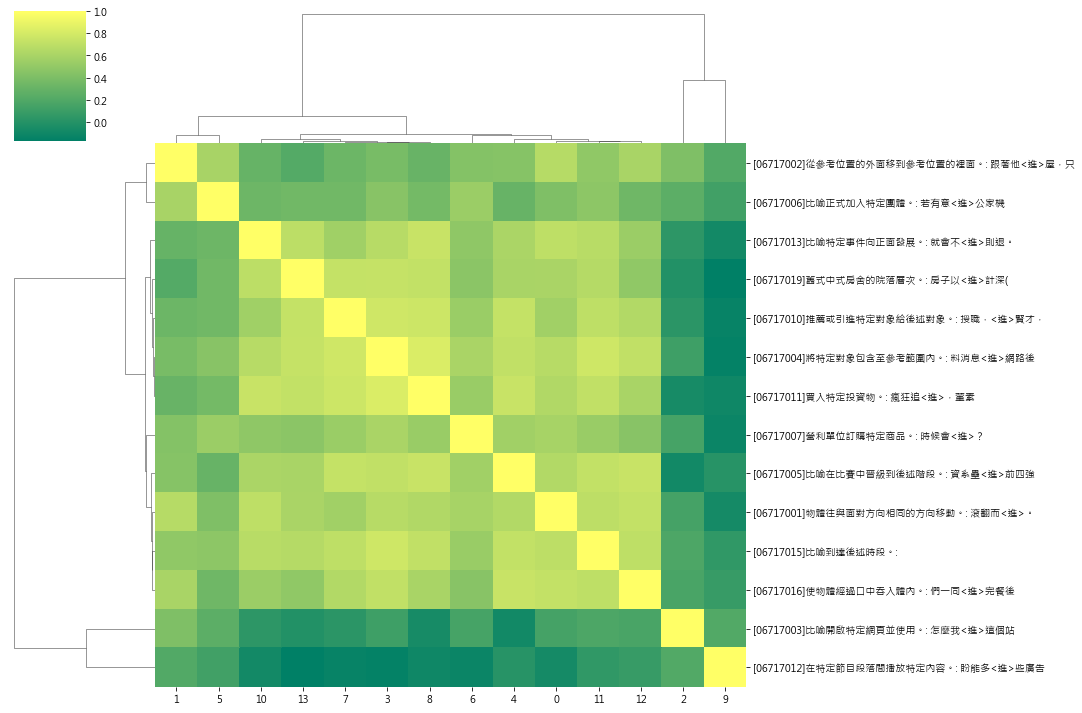

In [157]:
sns.clustermap(vecs.dot(vecs.T), metric="cosine", method="complete", cmap="summer", yticklabels=slabels)
plt.gcf().set_figwidth(20)

## Playing around UMAP and HDBSCAN

In [188]:
import umap
import hdbscan
umap_inst = umap.UMAP(n_components=2, n_neighbors=2, metric='cosine', min_dist=0.1, random_state=4422)
proj = umap_inst.fit_transform(vecs)
clust = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=5).fit(proj)

In [190]:
umap_inst.graph_

<73x73 sparse matrix of type '<class 'numpy.float32'>'
	with 130 stored elements in Compressed Sparse Row format>

c:\python38\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\python38\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


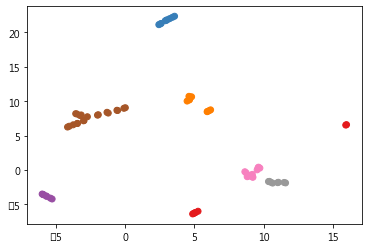

In [186]:
plt.scatter(proj[:,0], proj[:,1], c=clust.labels_, cmap="Set1")

In [187]:
clabels = clust.labels_
probs = clust.probabilities_
for clust_idx in np.unique(clabels):
    idx_list = (clabels==clust_idx).nonzero()[0]
    idx_list = sorted(idx_list, key=lambda x: -probs[x])    
    print("-- Cluster %d --" % (clust_idx,))    
    print("\n".join(f"{probs[i]:.2f}({sfreqs[i]:3d}): {slabels[i]}" for i in idx_list))
    print("\n")

-- Cluster -1 --
0.00(  4): [05229104]將蛋殼敲開，取得內容物。: 底鍋中<打>了三個
0.00(  7): [05229161]將條狀物互相纏繞成結，通常有固定或裝飾作用。: 穿西裝<打>絲巾會
0.00( 10): [05229156]到野外去尋找柴火或飼料。: 他還要<打>豬草，
0.00( 12): [05229193]從事臨時性非專職工作。: 是又工<打>得太累
0.00(  2): [05229195]向上級呈述事件的理由或經過。: 小報告<打>了上去
0.00( 13): [05229139]以鍵盤輸入文字。: 概可以<打>八十個
0.00(  3): [052291a7]手或腳拍打水面，以激起水花或得到反作用力。: 小腳腳<打><打>


-- Cluster 0 --
1.00( 38): [052291c1]做出後述手部動作，發出後述非口語的訊號。: ，賭客<打>暗號始
1.00( 87): [05229179]利用電話裝置與人通話。: 個電話<打>到我的
0.96( 40): [05229174]以特定方式傳達後述口語訊息。: 個還會<打>禪機呢
0.92( 20): [052291c0]以言語或做肢體動作的方式問候他人。: 跟大家<打>聲招呼
0.92( 74): [05229199]強行前述對象住到後述地點，使其失去行動自由。: 把皇后<打>進冷宮
0.85( 13): [05229188]想辦法。: 往這兒<打>。
0.79( 85): [05229129]比喻以後述對象為攻擊對象，以降低權力、地位。: 一昧的<打>自己人
0.68( 36): [05229101]以手施力使手或手持物撞擊特定對象。: 用力的<打>一下桌
0.65(  2): [05229175]以毫無根據或漫無主題的方式溝通。: 倆打屁<打>得還真


-- Cluster 1 --
1.00( 53): [05229133]進行後述賽局，通常從過程中得到樂趣。: 兄弟倆<打>PS2
1.00(  2): [05229135]進行特定遊戲，以贏得後述獎品。: 也會有<打>香腸的
0.67( 44): [05229157]設置陷阱或以工具捕捉野生的動物。: 山中去<打>鳥。
0.61(361): [05229131]進行球類運動。: 球